In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from resizeimage import resizeimage as rsize
import os
import mapper

np.set_printoptions(suppress=True)

def resize_image(img_path, size, savepath):
    img = Image.open(img_path)
    rootpath, filename = os.path.split(img_path)
    if(savepath is None):
        savepath = "{}/resized".format(rootpath)
    if(not os.path.exists(savepath)):
            os.makedirs(savepath)
    saver = savepath + "/" + filename
    
    
    try:
        img = rsize.resize_height(img, size)
    except Exception:
        img.save(saver, img.format)
    
    img.save(saver, img.format)
    return(savepath)

def gen_features(gray_img, alg):
    obj = cv2.xfeatures2d.SIFT_create()
    if(alg == "SURF"):
        obj = cv2.xfeatures2d.SURF_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = obj.detectAndCompute(gray_img, None)
    return kp, desc

def change_filepath(path, num, alg, read):
    ret = None
    if(read):
        rpath = os.path.splitext(path)
        ret = "{} ({}){}".format(rpath[0], num, rpath[1])
    if(not read):
        ret = "{}_{}_{}".format(path, alg, num)
    return ret

def readImagesCreateFeatures(num, readpath, savepath, alg):
    algNum = 1
    if(alg == "Both"):
        algNum = 2
    img_data_array = [[] for i in range(num * algNum)]
    for i in range(num):
        rpath = readpath
        if(num > 1):
            rpath = change_filepath(rpath, i+1, alg, True)
        print(rpath)
        image = cv2.imread(rpath)
        grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        algo = alg
        for j in range(algNum):
            if(alg == "Both"):
                if(j == 0):
                    algo = "SIFT"
                else:
                    algo = "SURF"
            kp, desc = gen_features(grey, algo)
            if(num == 1):
                img_data_array = [image, grey, kp, desc]
            else:
                img_data_array[num*j + i] = [image, grey, kp, desc]                
            if(savepath is not None):
                spath = savepath
                spath = change_filepath(spath, i+1, algo, False)
                np.save(spath, desc)
    return img_data_array

def mapper_metric(intrinsic, k, eps):
    if(intrinsic):
        return (True, k, eps)
    else:
        return (False, k, eps)

def filter_function(filter_func, mpar, current_data):
    f = None
    param2 = ""
    param3 = ""
    param4 = ""
    if(filter_func[2] is not None):
        param2 = " {}".format(filter_func[2])
    if(filter_func[3] is not None):
        param3 = " {}".format(filter_func[3])
    if(filter_func[4] is not None):
        param4 = " {}".format(filter_func[4])
    f_name = "{} {}{}{}{}".format(filter_func[0], filter_func[1], param2, param3, param4)
    if(filter_func[0] == "ecc"):
        f = mapper.filters.eccentricity(current_data, metricpar=mpar, exponent=filter_func[1])
    elif(filter_func[0] == "kNN"):
        f = mapper.filters.kNN_distance(current_data, metricpar=mpar, k=filter_func[1])   
    elif(filter_func[0] == "dist"):
        f = mapper.filters.distance_to_measure(current_data, metricpar=mpar, k=filter_func[1])   
    elif(filter_func[0] == "dens"):
        f = mapper.filters.Gauss_density(current_data, metricpar=mpar, sigma=filter_func[1])
    elif(filter_func[0] == "grLa"):
        f = mapper.filters.graph_Laplacian(current_data, metricpar=mpar,
                                           k=filter_func[1], eps=filter_func[2], 
                                          weighted_edges=filter_func[3], n=filter_func[4])
    elif(filter_func[0] == "eig"):
        f = mapper.filters.dm_eigenvector(current_data, metricpar=mpar,
                                          k=filter_func[1], mean_center=filter_func[2])
    elif(filter_func[0] == "zero"):
        f = mapper.filters.zero_filter(current_data)
    return f, f_name

def cover_function(cover_params):
    cover = None
    if(cover_params[0] == "uni"):
        cover = mapper.cover.cube_cover_primitive(intervals=cover_params[1], overlap=cover_params[2])
    elif(cover_params[0] == "bal"):
        cover = mapper.cover.balanced_cover_1d(intervals=cover_params[1], overlap=cover_params[2])
    c_name = "{} {} {}".format(cover_params[0], cover_params[1], cover_params[2])
    return cover, c_name

def cluster_function(cluster_num):
    clusters = [mapper.single_linkage(), mapper.complete_linkage(), mapper.average_linkage(), 
                mapper.weighted_linkage(), mapper.median_linkage(), mapper.centroid_linkage(), mapper.ward_linkage()]
    return clusters[cluster_num]

def cutoff_function(cutoff_func):
    cutoff = None
    if(cutoff_func[0] == "1st"):
        cutoff = mapper.cutoff.first_gap(gap = cutoff_func[1])
    elif(cutoff_func[0] == "hist"):
        cutoff = mapper.cutoff.histogram(bins = cutoff_func[1])
    elif(cutoff_func[0] == "big"):
        cutoff = mapper.cutoff.variable_exp_gap(exponent = cutoff_func[1], maxcluster = cutoff_func[2])
    elif(cutoff_func[0] == "big2"):
        cutoff = mapper.cutoff.variable_exp_gap2(exponent = cutoff_func[1], maxcluster = cutoff_func[2])
    param2 = ""
    if(cutoff_func[2] is not None):
        param2 = " {}".format(cutoff_func[2])
    c_name = "{} {}{}".format(cutoff_func[0], cutoff_func[1], param2)
    return cutoff, c_name

def produceMapperOutput(alg, data, path, metric, filter_func, cover_params, cluster_num, cutoff_func, savenum):
    algNum = 1
    if(alg == "Both"):
        algNum = 2
    for a in range(algNum):
        num_data = int(len(data)/algNum)
        print(num_data)
        for i in range(num_data):
            algo = alg
            if(alg == "Both"):
                if(a == 1):
                    algo = "SURF"
                else:
                    algo = "SIFT"
            current_data = data[a*num_data + i].astype(np.float)
            
            append_num = i+1
            if(savenum is not None):
                append_num = savenum
            
            #preprocessing
            point_labels = None
            mask = None
            Gauss_density = mapper.filters.Gauss_density
            kNN_distance  = mapper.filters.kNN_distance
            crop = mapper.crop
            #end preprocessing
            
            current_data, point_labels = mapper.mask_data(current_data, mask, point_labels)
            intrinsic_metric, k, eps = metric[0], metric[1], metric[2]
            
            met_name = "euc"
            
            is_vector_data = current_data.ndim != 1
            if (intrinsic_metric):
                if(is_vector_data):
                    metric = Euclidean
                data = mapper.metric.intrinsic_metric(current_data, k=1, eps=1.0)
                met_name = "int"
            
            metricpar = None
            if (is_vector_data):
                metricpar = {'metric': 'euclidean'}
                
                
            f, f_name = filter_function(filter_func, metricpar, current_data)
            
            cover, cov_name = cover_function(cover_params)
            
            cluster = cluster_function(cluster_num)
            
#             cover = mapper.cover.cube_cover_primitive(intervals=15, overlap=50.0)
#             cluster = mapper.average_linkage()
            
            if (not is_vector_data):
                metricpar = {}
            mapper_output = mapper.mapper(current_data, f, cover=cover, cluster=cluster, point_labels=point_labels,
                cutoff=None, metricpar=metricpar)
            
            cutoff, cut_name = cutoff_function(cutoff_func)
                      
            savepath = "{}/{}/{}, {}, {}, clus {}, {}/{}_output_{}".format(path, algo, met_name, f_name, cov_name, cluster_num+1, cut_name, algo, append_num)
            scalesave = "{}/{}/{}, {}, {}, clus {}, {}/{}_scale_graph_{}".format(path, algo, met_name, f_name, cov_name, cluster_num+1, cut_name, algo, append_num)
            savedir = "{}/{}/{}, {}, {}, clus {}, {}".format(path, algo, met_name, f_name, cov_name, cluster_num+1, cut_name)
            
            if(not os.path.exists(savedir)):
                os.makedirs(savedir)
            
            mapper_output.cutoff(cutoff, f, cover=cover, simple=False)
            mapper_output.draw_scale_graph()
            plt.savefig(scalesave)
            
            # Node coloring
            node_color = None
            name = "default"
            minsizes = []
            mapper_output.draw_2D(minsizes=minsizes,
                node_color=node_color,
                node_color_scheme=name)

            plt.savefig(savepath)
    print("finished!")

In [19]:
# for i in range(15):
#     path = "../images/randoms/{}random ({}).jpg"
#     read = path.format("", i+1)
#     save = path.format("resized/", i+1)
#     resize_image(read, 512, save)

randoms = readImagesCreateFeatures(15, "../images/randoms/resized/random.jpg", None, "Both")

../images/randoms/resized/random (1).jpg
../images/randoms/resized/random (2).jpg
../images/randoms/resized/random (3).jpg
../images/randoms/resized/random (4).jpg
../images/randoms/resized/random (5).jpg
../images/randoms/resized/random (6).jpg
../images/randoms/resized/random (7).jpg
../images/randoms/resized/random (8).jpg
../images/randoms/resized/random (9).jpg
../images/randoms/resized/random (10).jpg
../images/randoms/resized/random (11).jpg
../images/randoms/resized/random (12).jpg
../images/randoms/resized/random (13).jpg
../images/randoms/resized/random (14).jpg
../images/randoms/resized/random (15).jpg


15
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [483.04, 617.72]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Level: (3,)
Filter level (0,) has 91 points.
Filter level (1,) has 157 points.
Level: (4,)Filter level (2,) has 217 points.

Level: (5,)Filter level (3,) has 265 points.

Filter level (4,) has 265 points.
Filter level (5,) has 293 points.
Level: (6,)
Filter level (6,) has 319 points.
Level: (7,)
Level: (8,)
Level: (9,)
Filter level (7,) has 267 points.
Level: (10,)Filter level (8,) has 205 points.
Filter level (9,) has 143 points.

Level: (11,)
Level: (12,)
Filter level (10,) has 82 points.Level: (13,)

Filter level (11,) has 44 points.
Level: (14,)
Filter level (12,) has 21 points.
Filter level (13,) has 10 points.
Filter level (14,) has 6 points.


Filter level (9,) has 794 points.
Filter level (10,) has 435 points.
Filter level (11,) has 198 points.
Filter level (12,) has 98 points.
Filter level (13,) has 48 points.
Filter level (14,) has 18 points.
Scale graph path: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
There are 15 nodes.
Generate the simplicial complex.
Collect simplices of dimension 1:
There are 14 simplices of dimension 1.
Collect simplices of dimension 2:
There are 0 simplices of dimension 2.
Dimension: 1
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [464.65, 601.77]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)Filter level (0,) has 13 points.

Level: (2,)
Filter level (1,) has 20 points.
Level: (3,)
Filter level (2,) has 25 points.
Level: (4,)
Filter level (3,) has 24 points.
Level: (5,)
Filter level (4,) has 25 

There are 17 nodes.
Generate the simplicial complex.
Collect simplices of dimension 1:
There are 16 simplices of dimension 1.
Collect simplices of dimension 2:
There are 0 simplices of dimension 2.
Dimension: 1
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.Mapper: Filter range in dimension 0: [466.98, 623.07]

Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Filter level (0,) has 12 points.
Level: (2,)
Filter level (1,) has 53 points.Level: (3,)

Filter level (2,) has 85 points.
Level: (4,)
Filter level (3,) has 93 points.
Level: (5,)
Filter level (4,) has 101 points.
Level: (6,)
Filter level (5,) has 96 points.
Level: (7,)
Filter level (6,) has 76 points.
Level: (8,)
Filter level (7,) has 53 points.
Level: (9,)
Filter level (8,) has 54 points.
Level: (10,)
Filter level (9,) has 61 points.
Level: (11,)
Filter l

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.55, 1.00]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Filter level (0,) has 355 points.
Level: (3,)Filter level (1,) has 791 points.

Level: (4,)
Filter level (2,) has 1065 points.
Filter level (3,) has 1082 points.
Level: (5,)
Level: (6,)
Level: (7,)
Level: (8,)
Level: (9,)
Level: (10,)
Level: (11,)
Level: (12,)
Level: (13,)
Level: (14,)
Filter level (4,) has 943 points.
Filter level (5,) has 805 points.
Filter level (6,) has 675 points.
Filter level (7,) has 552 points.
Filter level (8,) has 421 points.
Filter level (9,) has 293 points.
Filter level (10,) has 200 points.
Filter level (11,) has 113 points.
Filter level (12,) has 59 points.
Filter level (13,) has 26 points.
Filter level (14,) has 15 points.
S

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.56, 1.01]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Filter level (0,) has 149 points.
Level: (3,)
Filter level (1,) has 368 points.
Level: (4,)
Filter level (2,) has 578 points.Level: (5,)

Filter level (3,) has 680 points.
Level: (6,)Filter level (4,) has 635 points.

Filter level (5,) has 463 points.
Level: (7,)
Level: (8,)
Level: (9,)
Level: (10,)
Level: (11,)
Level: (12,)
Level: (13,)
Level: (14,)
Filter level (6,) has 319 points.
Filter level (7,) has 225 points.
Filter level (8,) has 173 points.
Filter level (9,) has 167 points.
Filter level (10,) has 148 points.
Filter level (11,) has 106 points.
Filter level (12,) has 65 points.
Filter level (13,) has 45 points.
Filter level (14,) has 24 points.
Sca

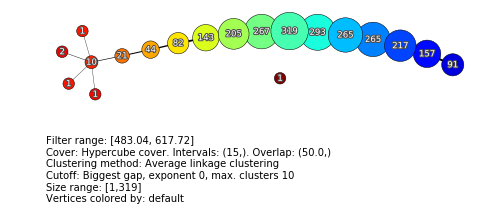

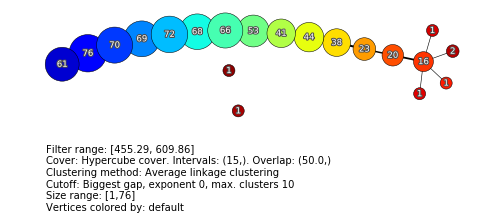

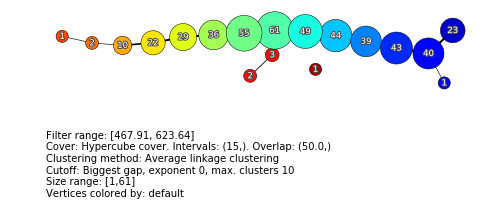

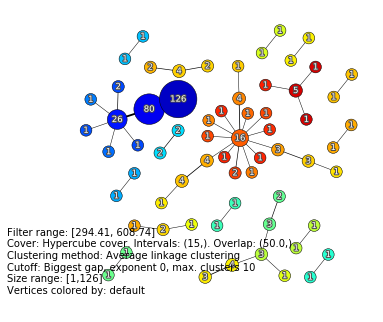

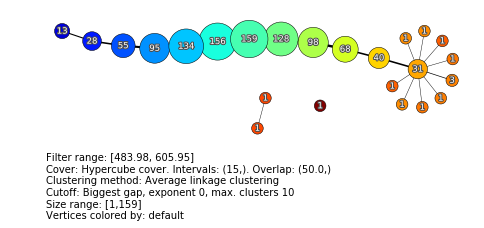

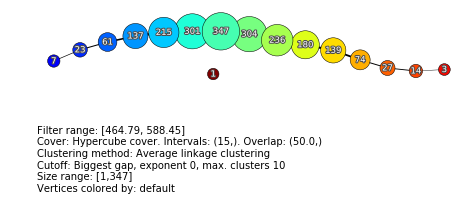

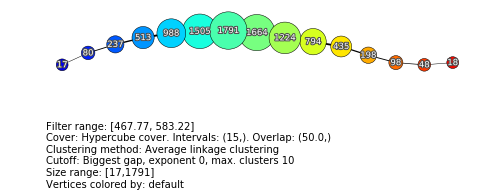

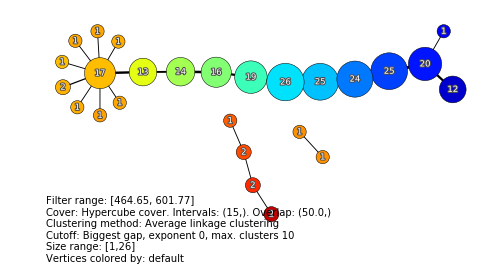

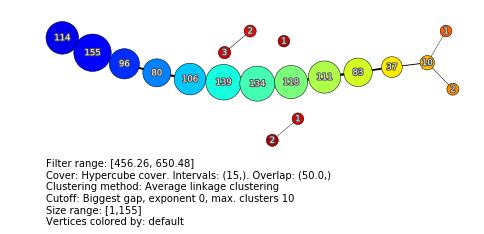

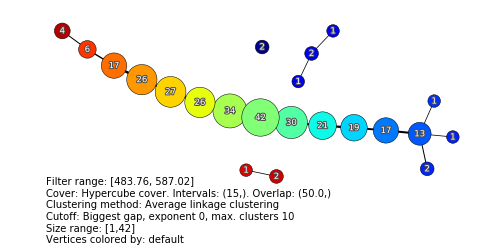

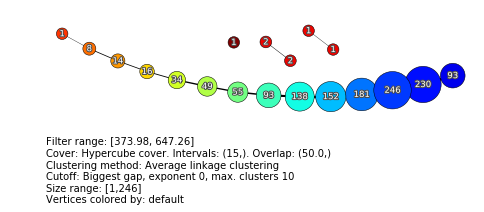

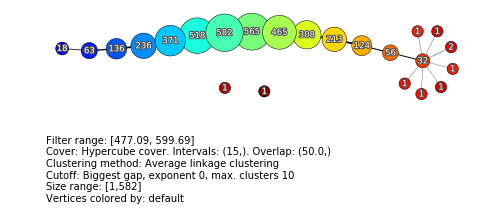

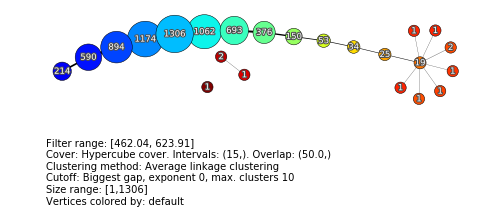

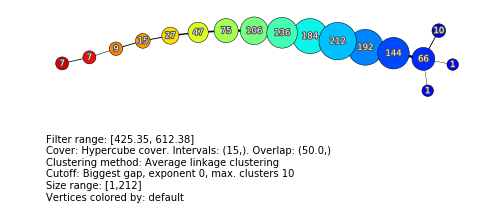

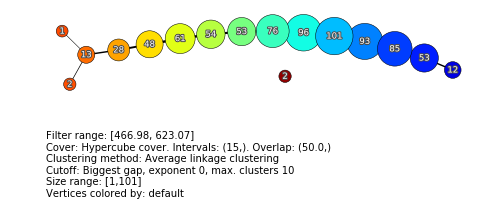

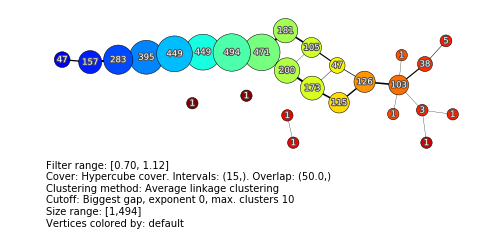

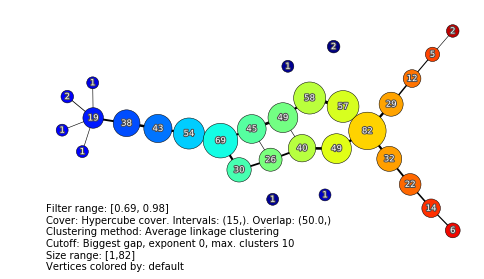

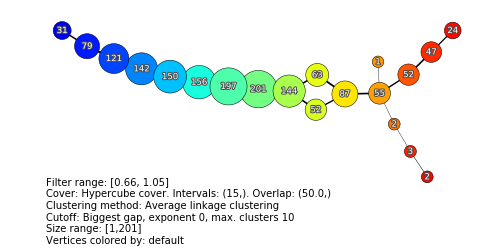

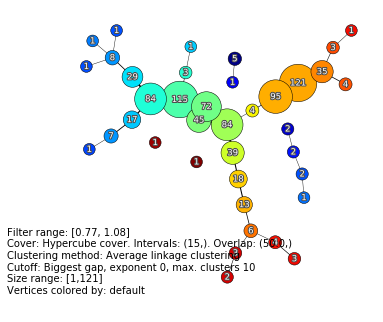

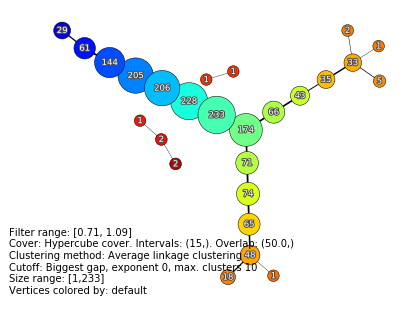

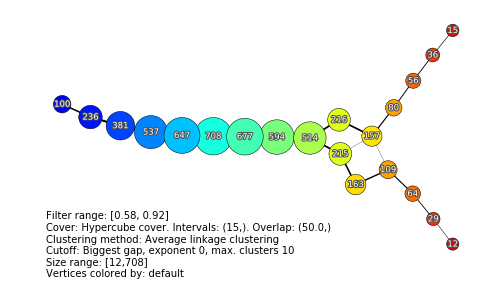

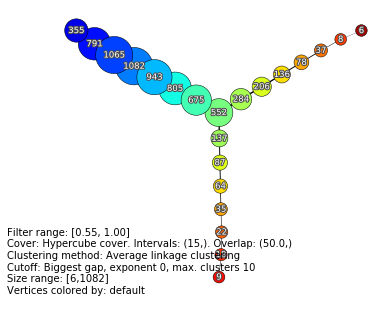

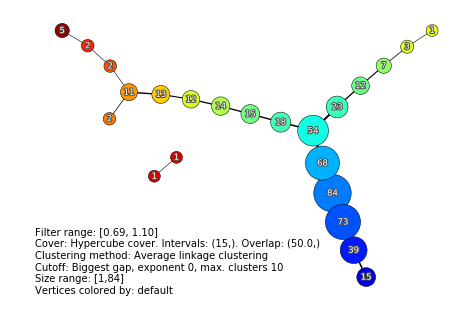

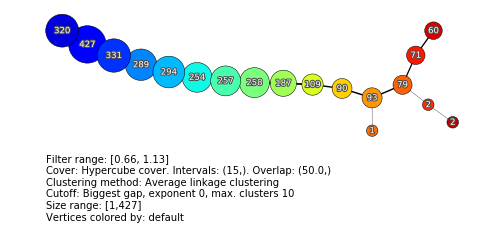

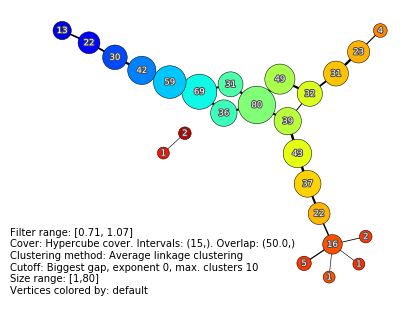

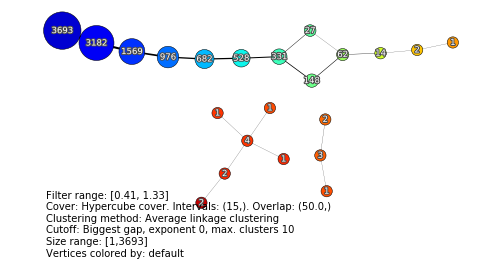

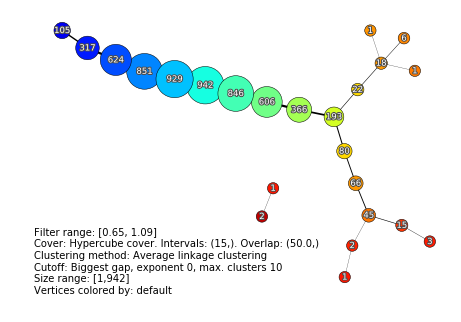

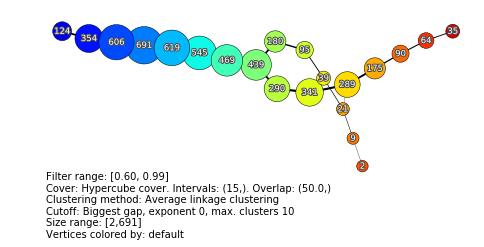

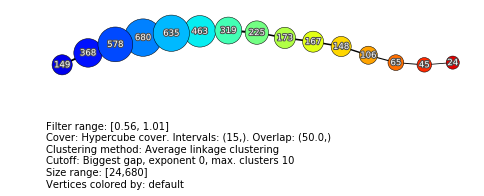

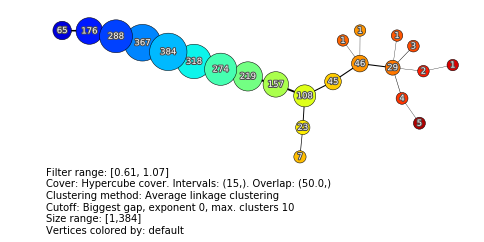

In [28]:
randomDescriptors = [data[3] for data in randoms]

metric = [False, None, None]
filter_func = ["ecc", 2, None, None, None]
cover_params = ["uni", 15, 50]
cluster_num = 2
cutoff_func = ["big", 0, 10]


produceMapperOutput("Both", randomDescriptors, "../mapper/mapper outputs/random",
                   metric=metric, filter_func=filter_func, cover_params=cover_params,
                   cluster_num=cluster_num, cutoff_func=cutoff_func)

13
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.66, 1.02]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Single linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Level: (3,)
Filter level (0,) has 62 points.
Filter level (1,) has 139 points.Level: (4,)

Filter level (2,) has 236 points.
Level: (5,)
Filter level (3,) has 300 points.
Level: (6,)
Filter level (4,) has 306 points.
Level: (7,)
Filter level (5,) has 304 points.
Filter level (6,) has 319 points.
Level: (8,)
Filter level (7,) has 306 points.Level: (9,)

Level: (10,)
Filter level (8,) has 239 points.
Level: (11,)
Filter level (9,) has 190 points.
Filter level (10,) has 137 points.
Level: (12,)
Filter level (11,) has 87 points.Level: (13,)

Filter level (12,) has 62 points.Level: (14,)

Filter level (13,) has 31 points.
Filter level (14,) has 14 points.
Sca

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.67, 1.02]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Single linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Filter level (0,) has 50 points.
Level: (3,)
Filter level (1,) has 102 points.
Level: (4,)Filter level (2,) has 139 points.

Level: (5,)
Filter level (3,) has 147 points.
Level: (6,)
Filter level (4,) has 177 points.Level: (7,)

Level: (8,)Filter level (5,) has 179 points.

Level: (9,)
Filter level (6,) has 168 points.
Filter level (7,) has 193 points.Level: (10,)

Level: (11,)
Level: (12,)Filter level (8,) has 181 points.

Filter level (9,) has 127 points.Level: (13,)

Level: (14,)Filter level (10,) has 96 points.

Filter level (11,) has 71 points.
Filter level (12,) has 31 points.
Filter level (13,) has 10 points.
Filter level (14,) has 4 points.
Scale gr

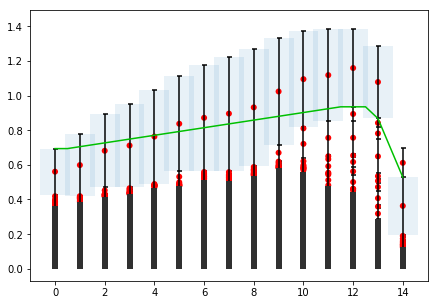

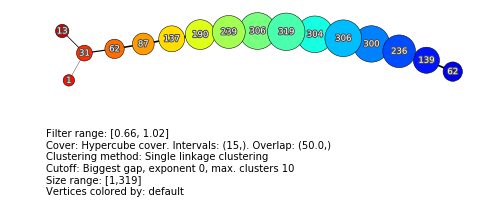

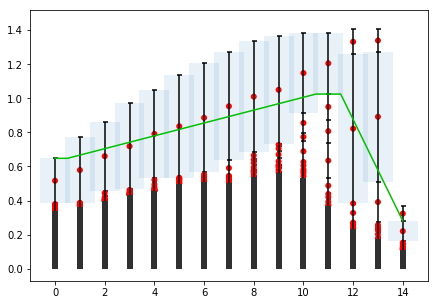

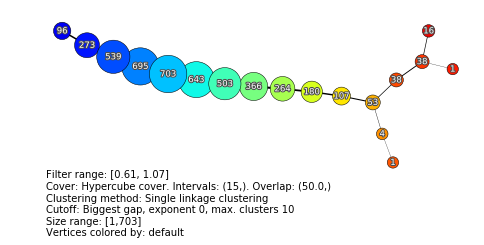

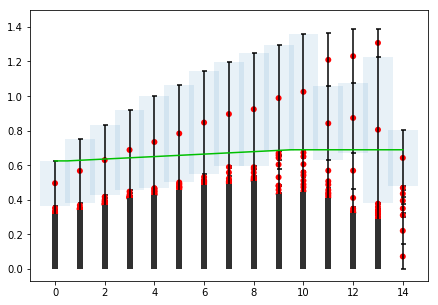

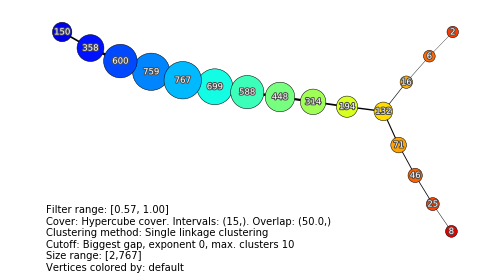

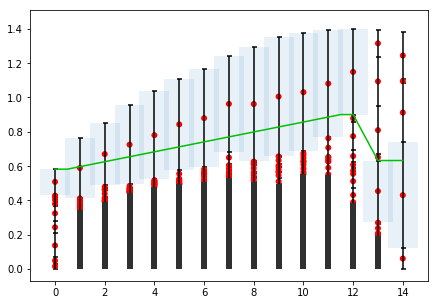

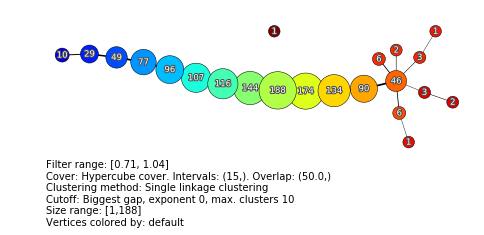

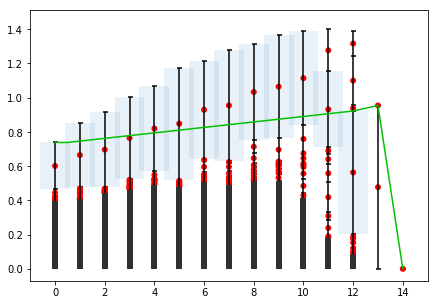

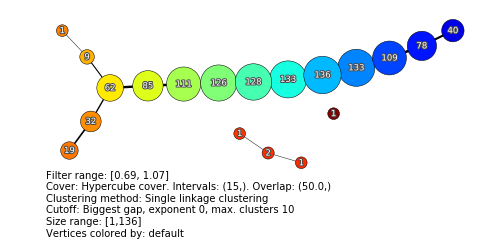

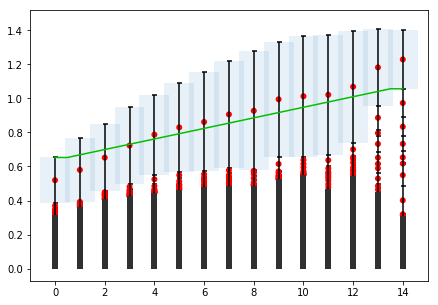

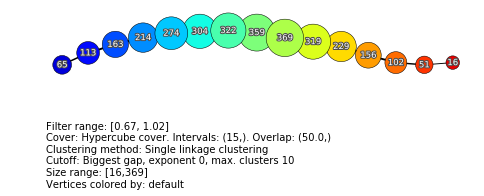

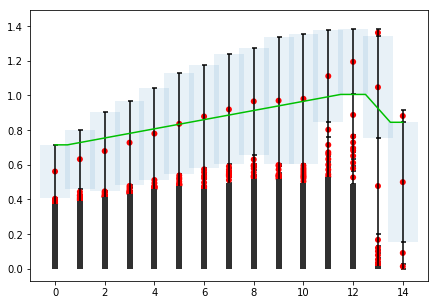

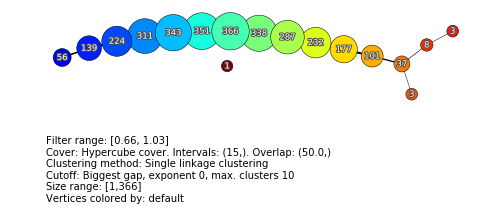

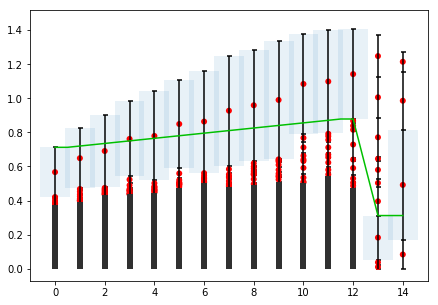

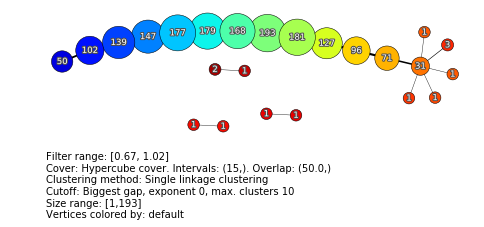

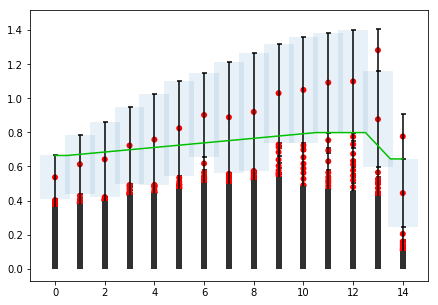

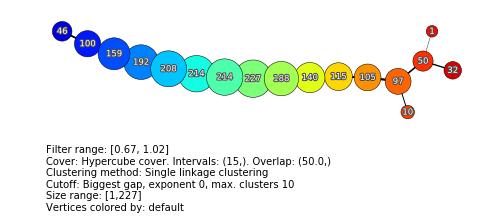

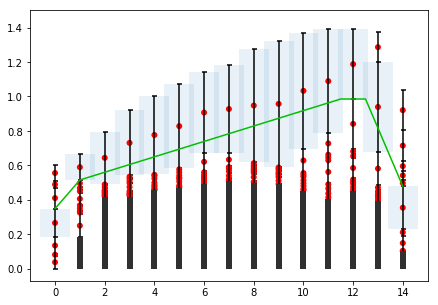

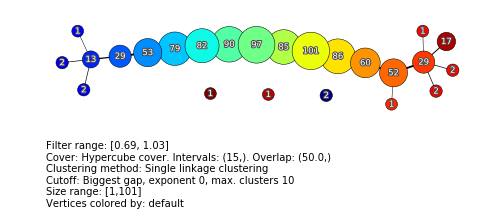

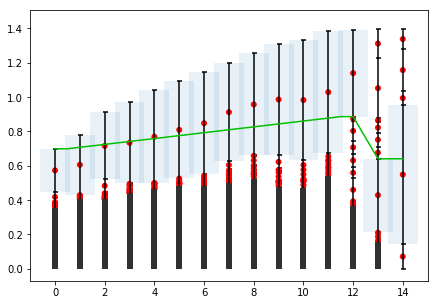

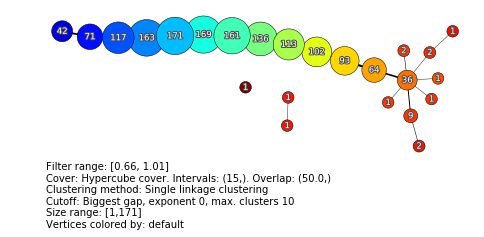

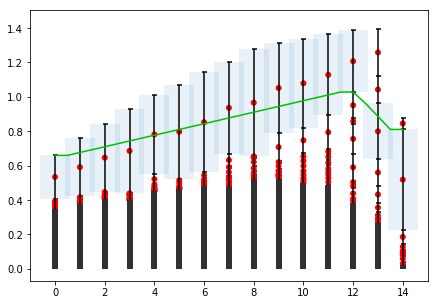

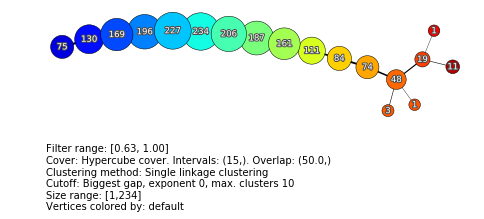

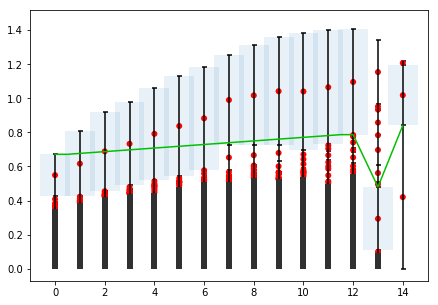

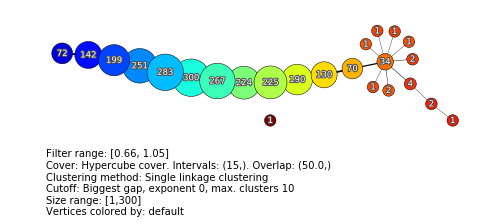

In [11]:
dogDescs = []
for i in range(13):
    dogDescs.append(np.load("./numpy vectors/dog_vectors/dog_SURF_{}.npy".format(i+1)))

metric = [False, None, None]
filter_func = ["ecc", 2, None, None, None]
cover_params = ["uni", 15, 50]
cutoff_func = ["big", 0, 10]
cluster_num = 0
                    
produceMapperOutput("SURF", dogDescs, "../mapper/mapper outputs/dog",
                   metric=metric, filter_func=filter_func, cover_params=cover_params,
                   cluster_num=cluster_num, cutoff_func=cutoff_func)

In [2]:
fullSizedRandoms = readImagesCreateFeatures(15, "../images/randoms/random.jpg", "./numpy vectors/random_vectors/full size/", "Both")

../images/randoms/random (1).jpg
../images/randoms/random (2).jpg
../images/randoms/random (3).jpg
../images/randoms/random (4).jpg
../images/randoms/random (5).jpg
../images/randoms/random (6).jpg
../images/randoms/random (7).jpg
../images/randoms/random (8).jpg
../images/randoms/random (9).jpg
../images/randoms/random (10).jpg
../images/randoms/random (11).jpg
../images/randoms/random (12).jpg
../images/randoms/random (13).jpg
../images/randoms/random (14).jpg
../images/randoms/random (15).jpg


In [3]:
for i in range(30):
    j = i+1
    alg = "SIFT"
    if(i > 14):
        alg = "SURF"
        j = i - 14
    pathpre = "./numpy vectors/random_vectors/full size/"
    os.rename(pathpre + "_{}_{}.npy".format(alg, j), pathpre + "random_{}_{}.npy".format(alg, j))

In [ ]:
full_random_descs = []
for i in range(5, 15):
    full_random_descs.append(np.load("./numpy vectors/random_vectors/full size/random_SURF_{}.npy".format(i+1)))

metric = [False, None, None]
filter_func = ["ecc", 2, None, None, None]
cover_params = ["uni", 15, 50]
cluster_num = 2
cutoff_func = ["big", 0, 10]
    
produceMapperOutput("SURF", [full_random_descs[0]], "../mapper/mapper outputs/random/full size/",
                   metric=metric, filter_func=filter_func, cover_params=cover_params,
                   cluster_num=cluster_num, cutoff_func=cutoff_func, savenum=6)

1
{'metric': 'euclidean'}


In [6]:
for i in range(53):
    print(i+1)
    resize_image("../images/many sunsets/sunset ({}).jpg".format(i+1), 1024, None)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


IOError: [Errno 2] No such file or directory: '../images/many sunsets/sunset (54).jpg'

In [9]:
readImagesCreateFeatures(53, "../images/many sunsets/resized/sunset.jpg", "./numpy vectors/many_sunset_vectors/", "SURF")

../images/many sunsets/resized/sunset (1).jpg
../images/many sunsets/resized/sunset (2).jpg
../images/many sunsets/resized/sunset (3).jpg
../images/many sunsets/resized/sunset (4).jpg
../images/many sunsets/resized/sunset (5).jpg
../images/many sunsets/resized/sunset (6).jpg
../images/many sunsets/resized/sunset (7).jpg
../images/many sunsets/resized/sunset (8).jpg
../images/many sunsets/resized/sunset (9).jpg
../images/many sunsets/resized/sunset (10).jpg
../images/many sunsets/resized/sunset (11).jpg
../images/many sunsets/resized/sunset (12).jpg
../images/many sunsets/resized/sunset (13).jpg
../images/many sunsets/resized/sunset (14).jpg
../images/many sunsets/resized/sunset (15).jpg
../images/many sunsets/resized/sunset (16).jpg
../images/many sunsets/resized/sunset (17).jpg
../images/many sunsets/resized/sunset (18).jpg
../images/many sunsets/resized/sunset (19).jpg
../images/many sunsets/resized/sunset (20).jpg
../images/many sunsets/resized/sunset (21).jpg
../images/many sunsets

[[array([[[ 46,  68, 109],
          [ 47,  69, 110],
          [ 47,  69, 110],
          ..., 
          [ 52,  56,  85],
          [ 52,  56,  85],
          [ 52,  66,  85]],
  
         [[ 48,  70, 111],
          [ 49,  71, 112],
          [ 49,  71, 112],
          ..., 
          [ 52,  57,  82],
          [ 52,  57,  82],
          [ 46,  60,  78]],
  
         [[ 47,  69, 110],
          [ 48,  70, 111],
          [ 49,  71, 112],
          ..., 
          [ 52,  59,  79],
          [ 51,  58,  78],
          [ 44,  57,  73]],
  
         ..., 
         [[ 38,  49,  46],
          [ 31,  42,  39],
          [ 36,  45,  42],
          ..., 
          [103, 112, 115],
          [100, 109, 113],
          [ 82,  97,  83]],
  
         [[ 94, 103, 100],
          [ 93, 102,  99],
          [ 80,  90,  84],
          ..., 
          [102, 115, 113],
          [ 93, 107, 105],
          [107, 123, 100]],
  
         [[129, 138, 135],
          [118, 128, 122],
          [102, 109, 

In [12]:
for i in range(53):
    path = "./numpy vectors/many_sunset_vectors/"
    os.rename("{}_SURF_{}.npy".format(path, i+1), "{}sunsets_SURF_{}.npy".format(path, i+1))

53
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.Mapper: Filter range in dimension 0: [0.41, 1.01]

Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Filter level (0,) has 2031 points.Level: (3,)

Filter level (1,) has 4095 points.Level: (4,)

Filter level (2,) has 4297 points.
Level: (5,)Filter level (3,) has 3055 points.

Level: (6,)
Level: (7,)
Level: (8,)
Level: (9,)
Level: (10,)
Level: (11,)
Level: (12,)
Level: (13,)
Level: (14,)
Filter level (4,) has 1709 points.
Filter level (5,) has 846 points.
Filter level (6,) has 375 points.
Filter level (7,) has 154 points.
Filter level (8,) has 76 points.
Filter level (9,) has 65 points.
Filter level (10,) has 46 points.
Filter level (11,) has 20 points.
Filter level (12,) has 12 points.
Filter level (13,) has 29 points.
Filter level (14,) has 35 points.

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.55, 1.01]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Filter level (0,) has 860 points.Level: (3,)

Filter level (1,) has 1701 points.
Level: (4,)
Filter level (2,) has 2201 points.
Level: (5,)
Filter level (3,) has 2268 points.Level: (6,)

Level: (7,)
Level: (8,)
Level: (9,)
Level: (10,)
Level: (11,)
Level: (12,)
Level: (13,)
Level: (14,)
Filter level (4,) has 2005 points.
Filter level (5,) has 1654 points.
Filter level (6,) has 1301 points.
Filter level (7,) has 985 points.
Filter level (9,) has 587 points.Filter level (8,) has 737 points.

Filter level (10,) has 514 points.
Filter level (11,) has 402 points.
Filter level (12,) has 278 points.
Filter level (13,) has 188 points.
Filter level (14,) has 102 po

C:\Users\Shanik\AppData\Local\conda\conda\envs\TDAenv\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.72, 1.09]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Level: (3,)Filter level (0,) has 72 points.

Filter level (1,) has 165 points.Level: (4,)

Level: (5,)Filter level (2,) has 300 points.

Filter level (3,) has 516 points.
Level: (6,)
Filter level (4,) has 680 points.
Filter level (5,) has 812 points.
Filter level (6,) has 1027 points.
Level: (7,)
Level: (8,)
Level: (9,)
Level: (10,)
Level: (11,)
Level: (12,)
Level: (13,)
Level: (14,)
Filter level (7,) has 1101 points.
Filter level (8,) has 1135 points.
Filter level (9,) has 1202 points.
Filter level (10,) has 1059 points.
Filter level (11,) has 853 points.
Filter level (12,) has 479 points.
Filter level (13,) has 109 points.
Filter level (14,) has 19 point

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.Mapper: Filter range in dimension 0: [0.80, 1.04]

Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Filter level (0,) has 3 points.Level: (2,)

Warning! Filter level (1,) has only one point.
Level: (3,)
Filter level (2,) has 2 points.
Level: (4,)
Filter level (3,) has 3 points.
Level: (5,)
Filter level (4,) has 4 points.
Level: (6,)
Filter level (5,) has 4 points.
Level: (7,)Filter level (6,) has 5 points.

Level: (8,)
Filter level (7,) has 13 points.
Level: (9,)
Filter level (8,) has 13 points.
Level: (10,)
Filter level (9,) has 5 points.
Level: (11,)
Filter level (10,) has 2 points.
Level: (12,)
Warning! Filter level (11,) has only one point.
Level: (13,)
Filter level (12,) has 2 points.
Level: (14,)
Warning! Filter level (13,) has only one point.
Warning! Filter 

Filter level (4,) has 4011 points.
Filter level (5,) has 2788 points.
Filter level (6,) has 1812 points.
Filter level (7,) has 1092 points.
Filter level (8,) has 578 points.
Filter level (9,) has 248 points.
Filter level (10,) has 83 points.
Filter level (11,) has 27 points.
Filter level (12,) has 10 points.
Filter level (13,) has 8 points.
Filter level (14,) has 5 points.
Scale graph path: [1 1 1 1 1 2 2 2 2 2 3 3 2 1 3]
There are 27 nodes.
Generate the simplicial complex.
Collect simplices of dimension 1:
There are 29 simplices of dimension 1.
Collect simplices of dimension 2:
There are 0 simplices of dimension 2.
Dimension: 1
Draw nodes and dendrograms.
Done.
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.50, 0.98]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level

Draw nodes and dendrograms.
Done.
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.65, 1.03]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Level: (3,)
Filter level (0,) has 29 points.
Filter level (1,) has 81 points.
Level: (4,)Filter level (2,) has 167 points.

Level: (5,)
Filter level (3,) has 248 points.
Level: (6,)
Filter level (4,) has 294 points.
Level: (7,)
Filter level (5,) has 330 points.
Filter level (6,) has 383 points.
Filter level (7,) has 385 points.
Level: (8,)
Filter level (8,) has 388 points.
Level: (9,)
Filter level (9,) has 381 points.
Level: (10,)
Level: (11,)
Level: (12,)
Filter level (10,) has 278 points.
Level: (13,)
Filter level (11,) has 162 points.
Level: (14,)
Filter level (12,) has 71 points.
Filter level (13,) has 18 points.
Filte

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.Mapper: Filter range in dimension 0: [0.68, 1.04]

Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Filter level (0,) has 21 points.Level: (3,)

Filter level (1,) has 42 points.
Level: (4,)
Filter level (2,) has 73 points.
Level: (5,)
Filter level (3,) has 108 points.
Level: (6,)
Filter level (4,) has 132 points.
Level: (7,)
Filter level (5,) has 147 points.
Level: (8,)
Level: (9,)Filter level (6,) has 173 points.

Filter level (7,) has 186 points.
Level: (10,)
Level: (11,)Filter level (8,) has 201 points.

Filter level (9,) has 248 points.
Level: (12,)Filter level (10,) has 221 points.

Filter level (11,) has 116 points.Level: (13,)
Filter level (12,) has 60 points.

Level: (14,)
Filter level (13,) has 35 points.
Filter level (14,) has 13 points.
Scale 

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.62, 1.01]
Mapper: Cover: Hypercube cover. Intervals: (15,). Overlap: (50.0,)
Mapper: Clustering: Average linkage clustering
Mapper: Cutoff: None
Level: (0,)
Level: (1,)
Level: (2,)
Filter level (0,) has 50 points.
Filter level (1,) has 71 points.Level: (3,)

Filter level (2,) has 77 points.Level: (4,)

Filter level (3,) has 112 points.
Level: (5,)
Filter level (4,) has 149 points.
Level: (6,)
Filter level (5,) has 155 points.
Filter level (6,) has 160 points.Level: (7,)

Level: (8,)
Level: (9,)Filter level (7,) has 161 points.
Filter level (8,) has 170 points.

Level: (10,)
Level: (11,)
Filter level (9,) has 144 points.Level: (12,)

Filter level (10,) has 75 points.
Filter level (11,) has 40 points.
Level: (13,)Filter level (12,) has 28 points.

Level: (14,)
Filter level (13,) has 15 points.
Filter level (14,) has 4 points.
Scale gra

ValueError: object of too small depth for desired array

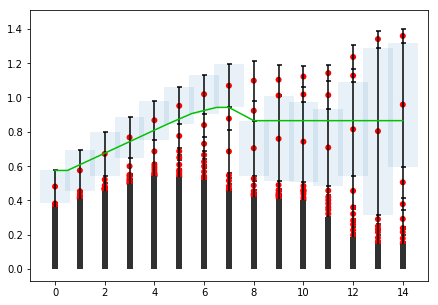

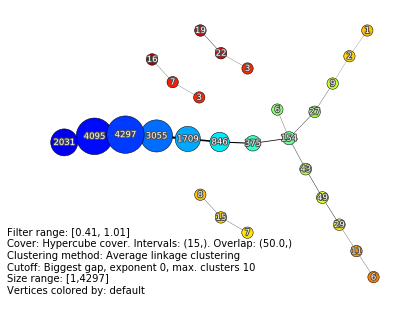

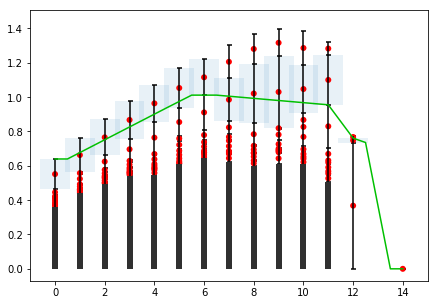

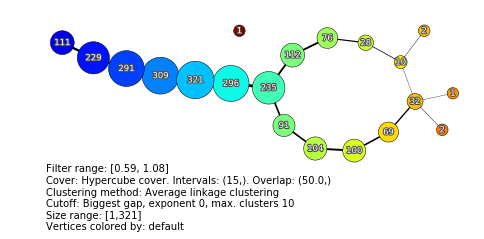

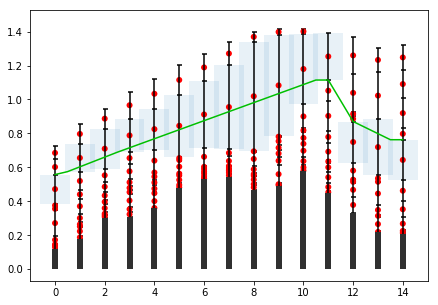

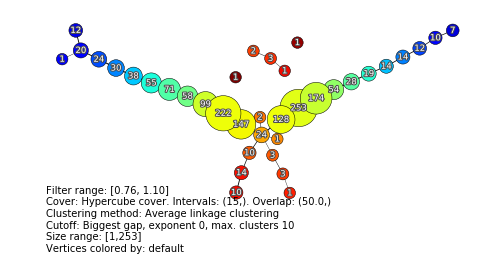

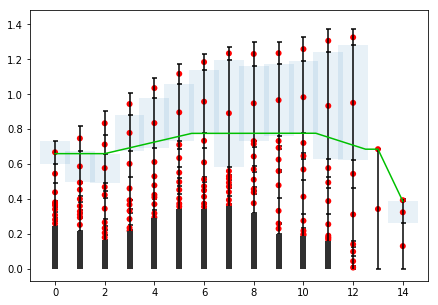

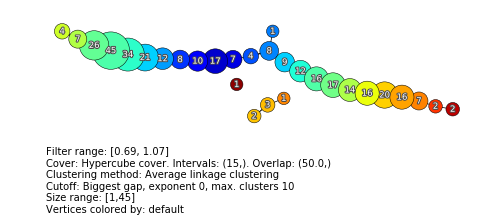

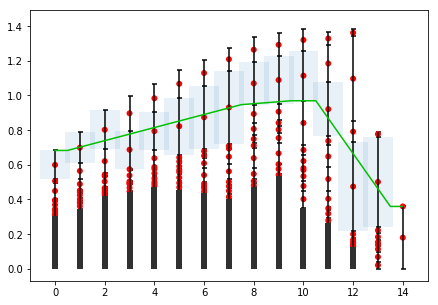

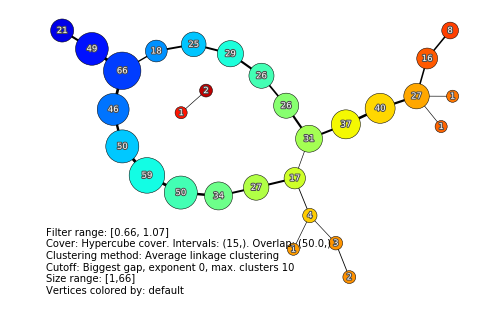

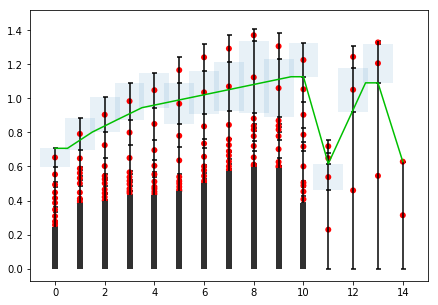

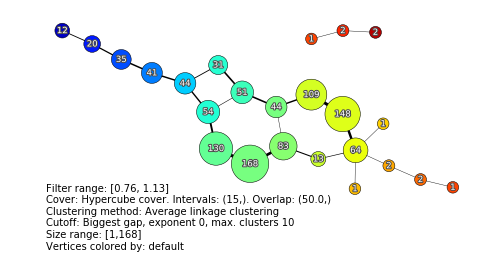

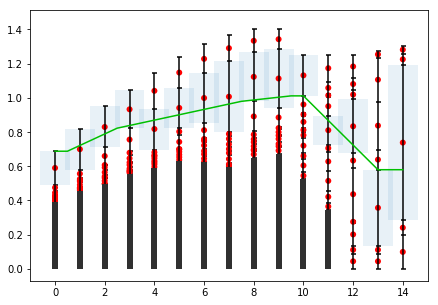

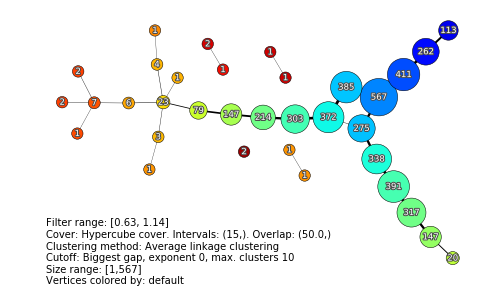

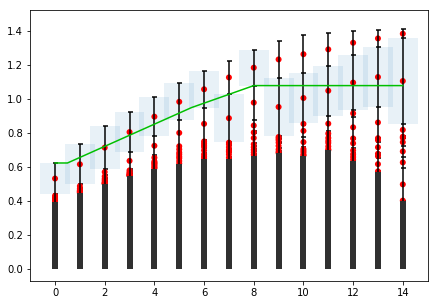

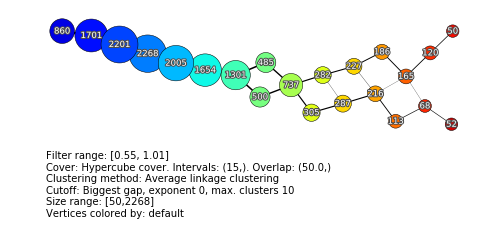

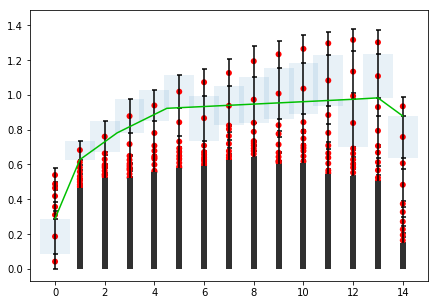

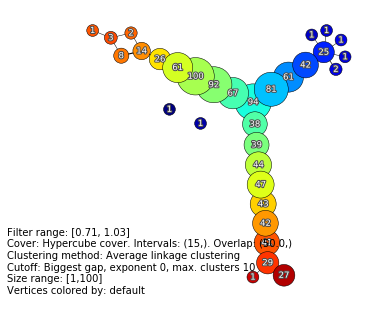

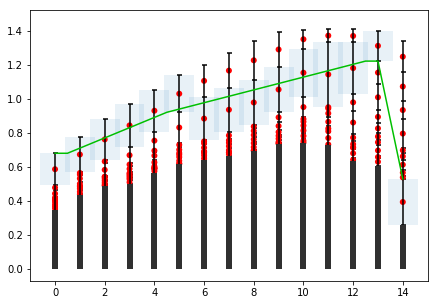

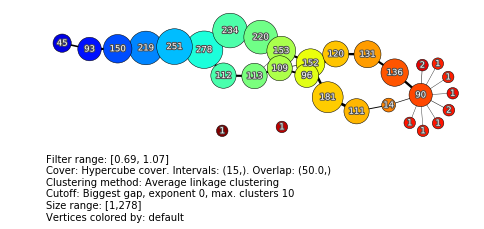

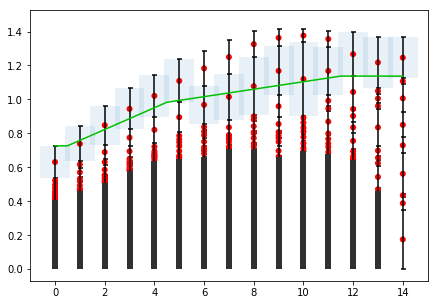

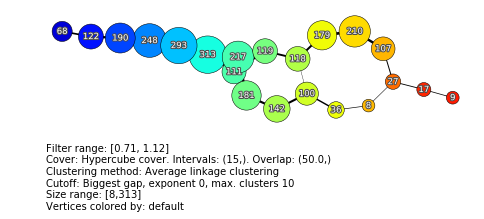

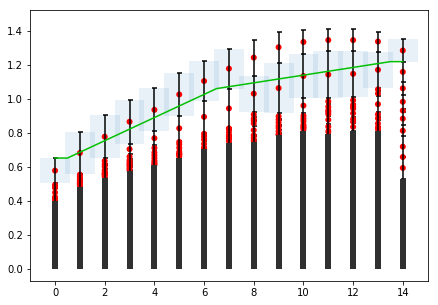

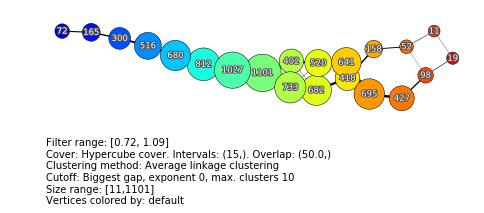

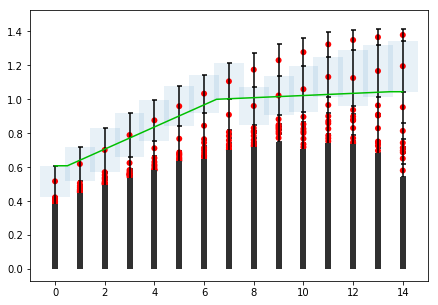

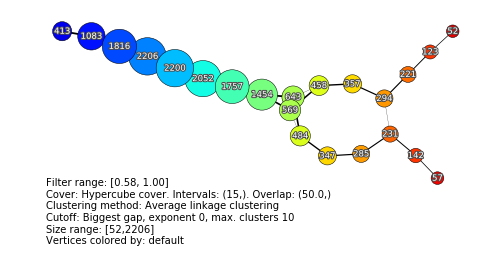

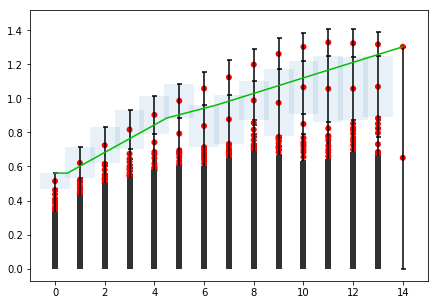

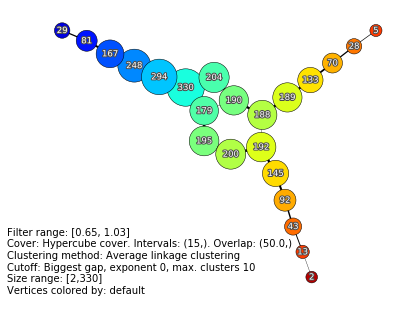

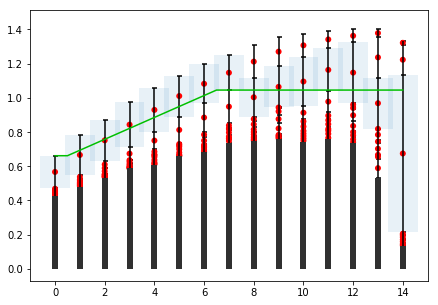

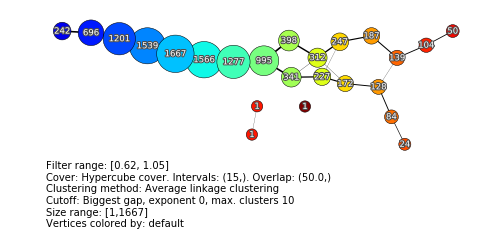

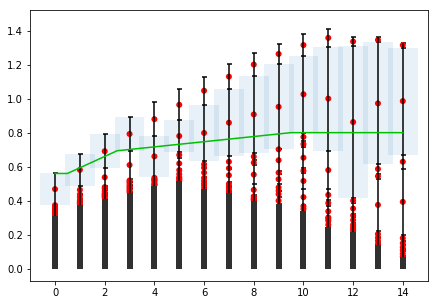

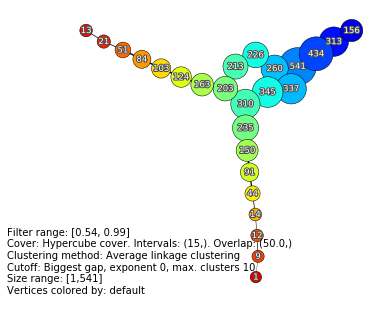

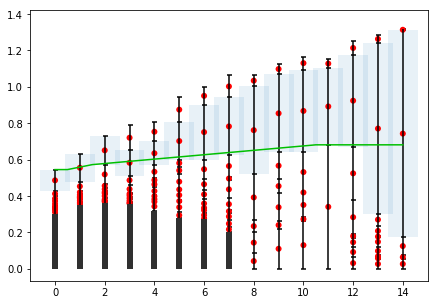

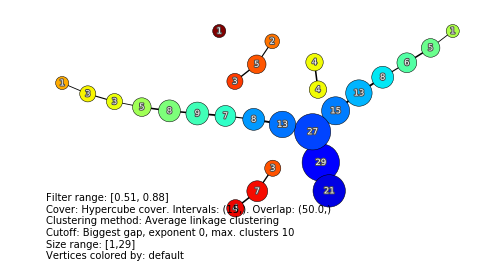

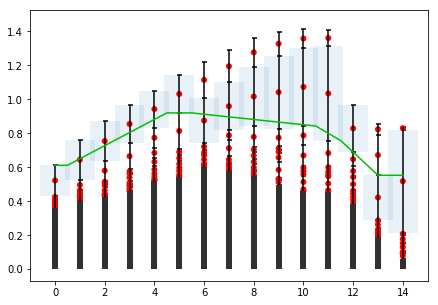

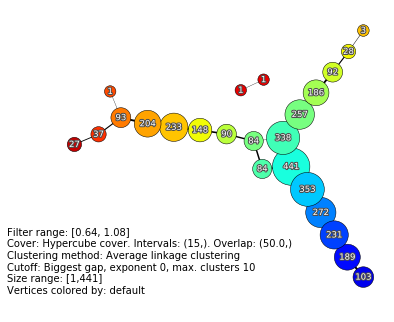

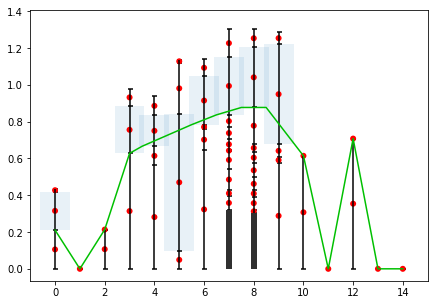

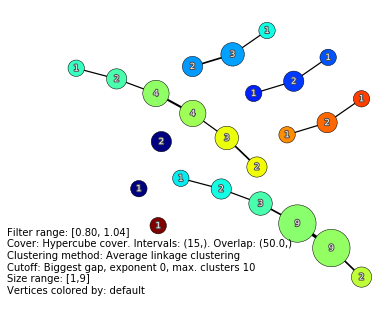

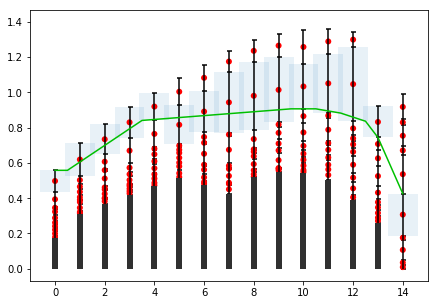

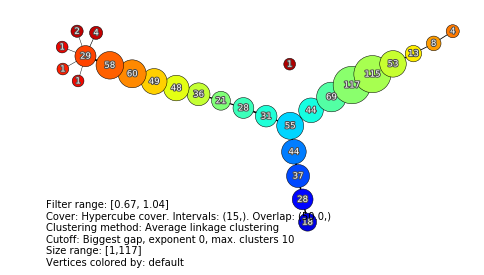

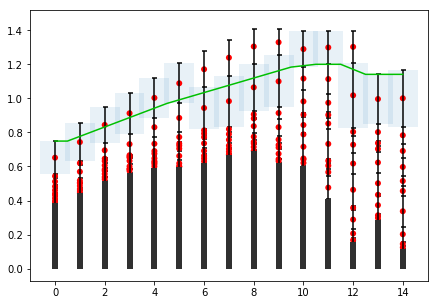

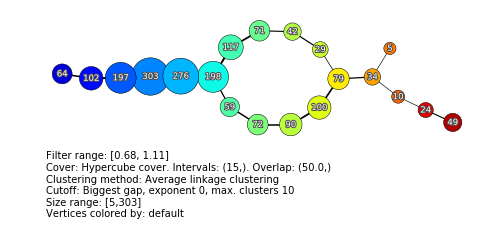

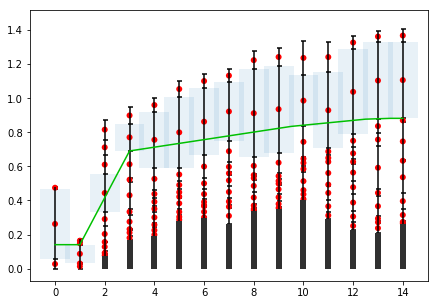

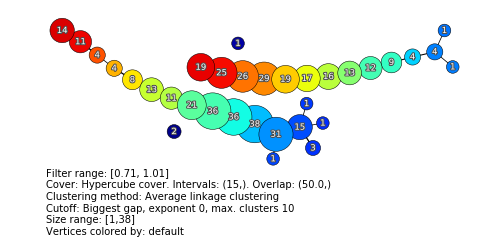

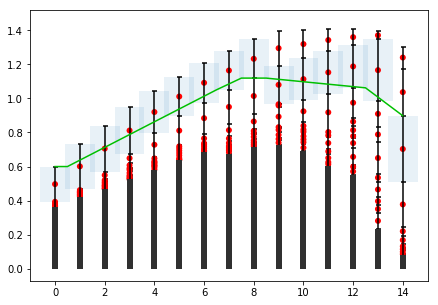

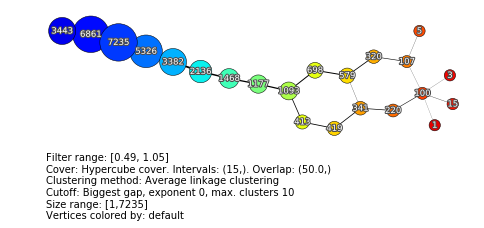

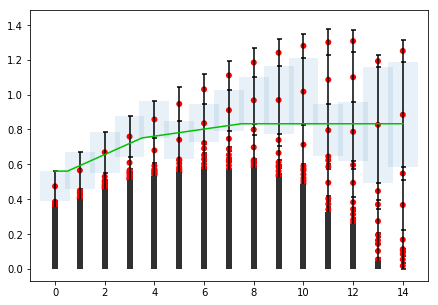

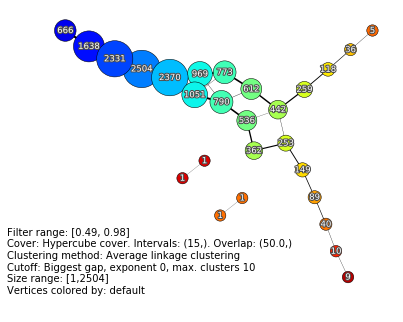

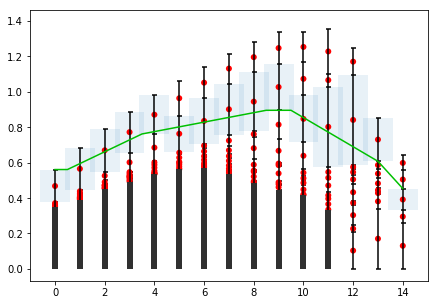

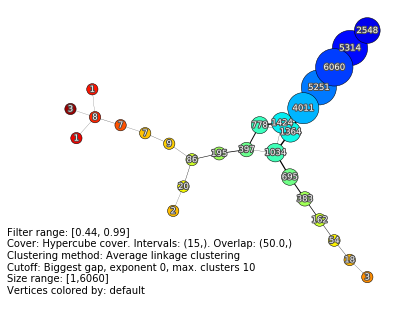

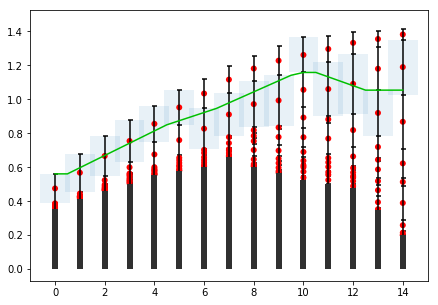

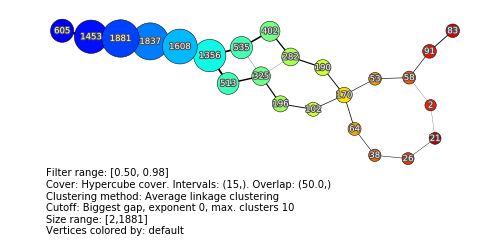

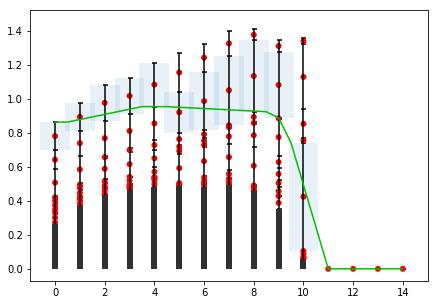

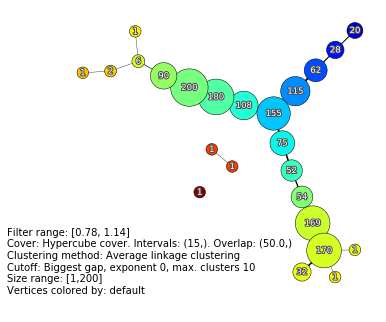

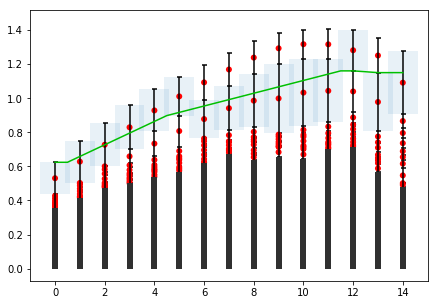

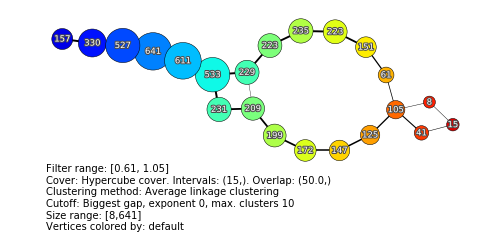

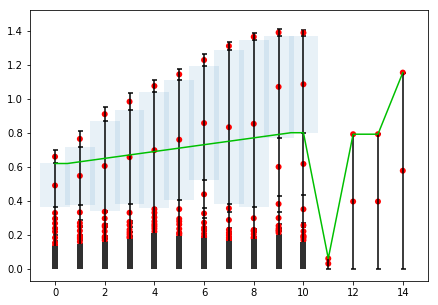

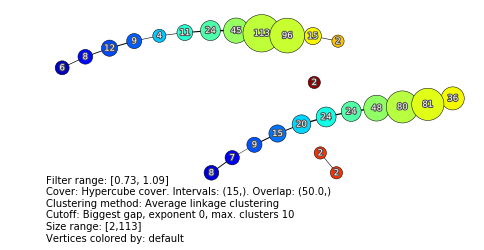

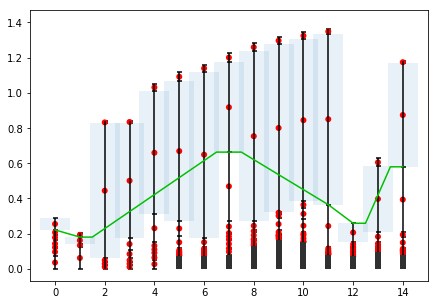

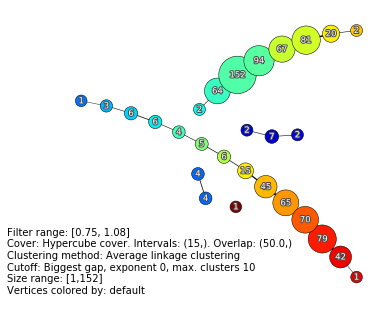

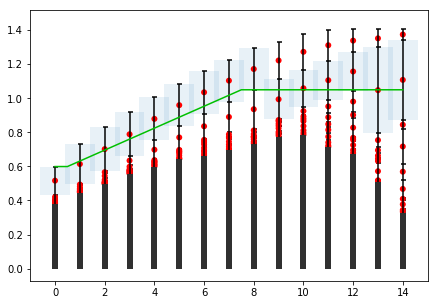

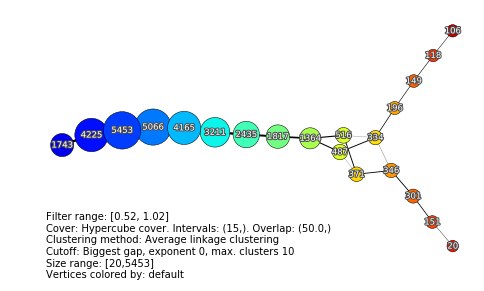

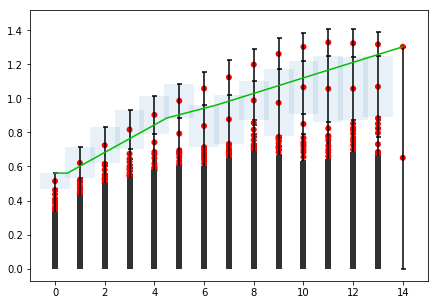

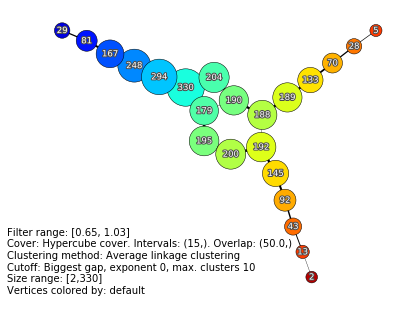

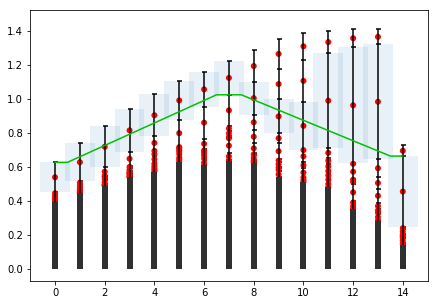

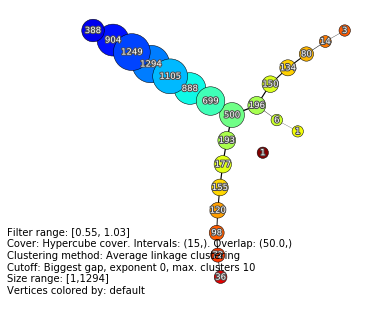

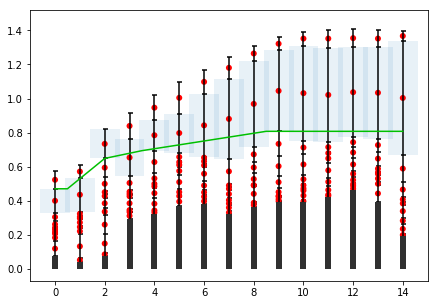

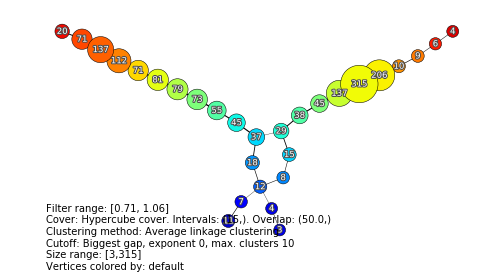

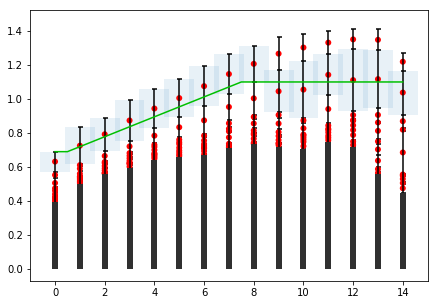

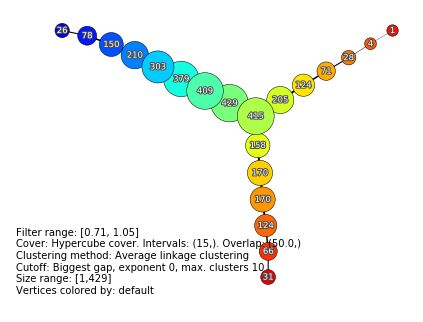

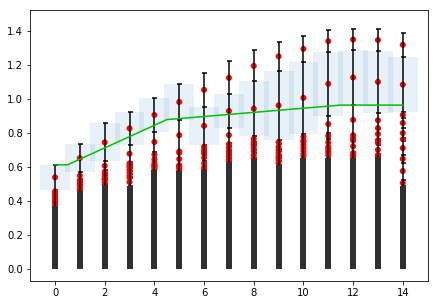

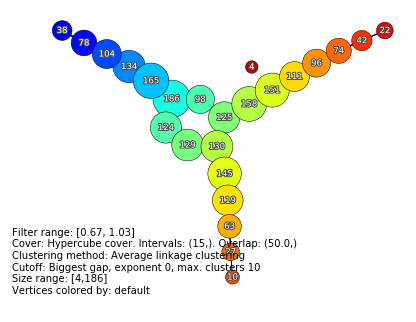

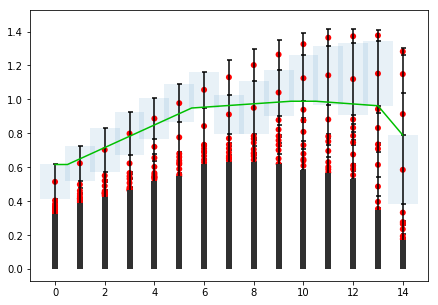

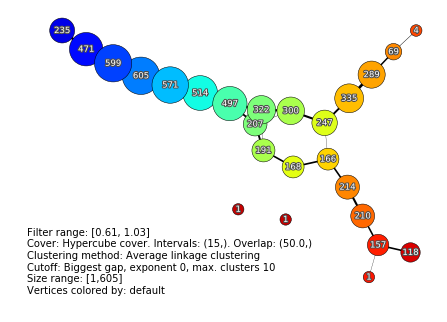

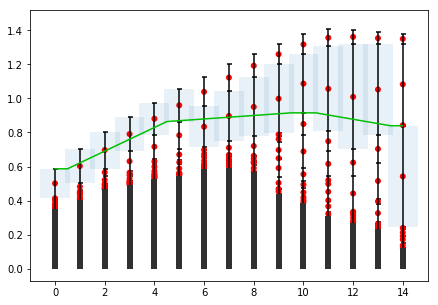

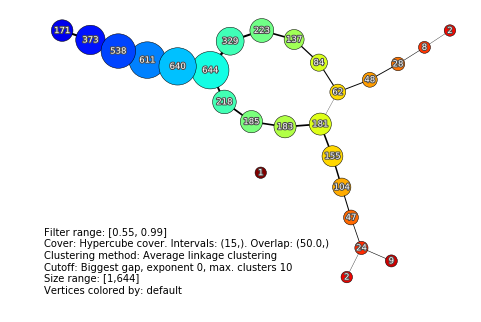

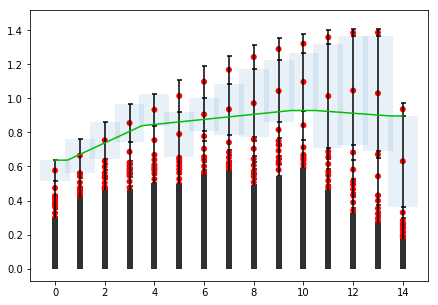

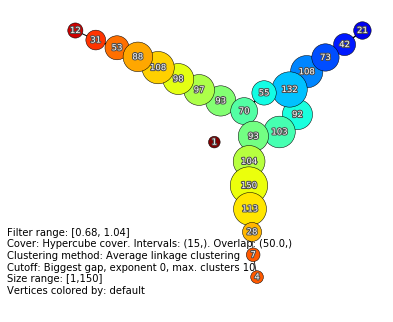

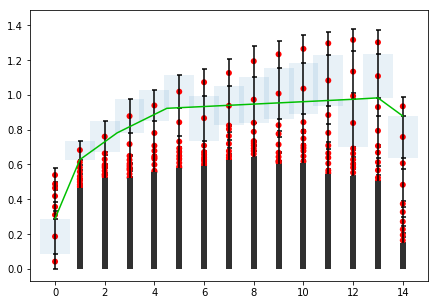

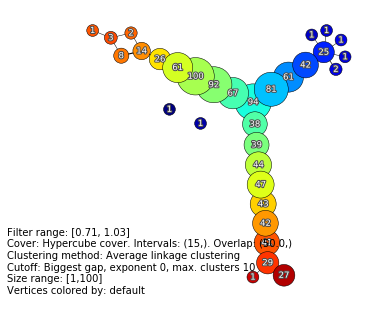

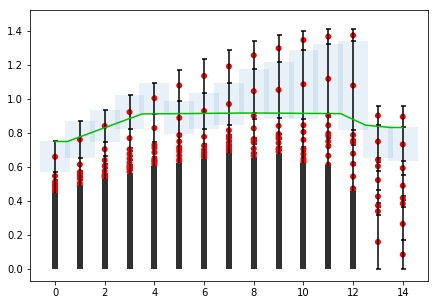

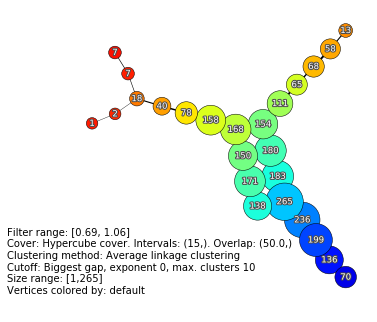

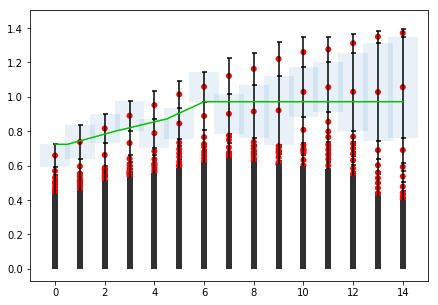

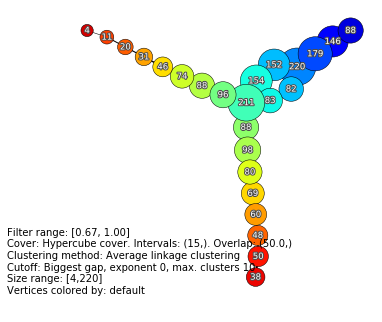

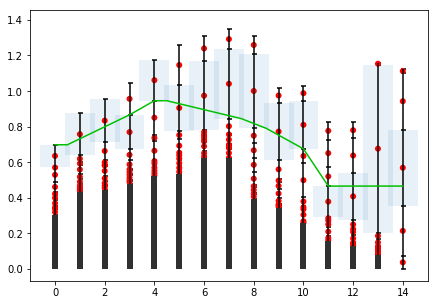

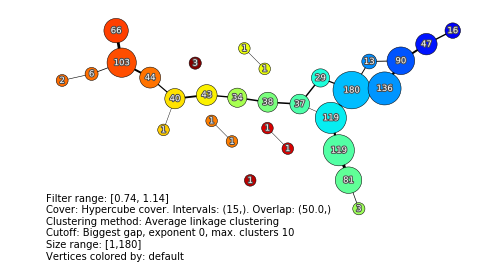

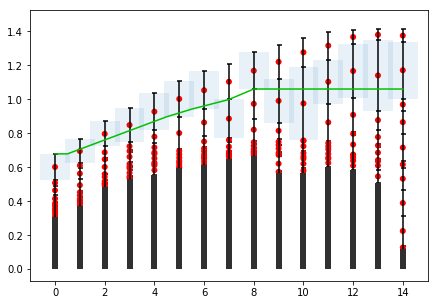

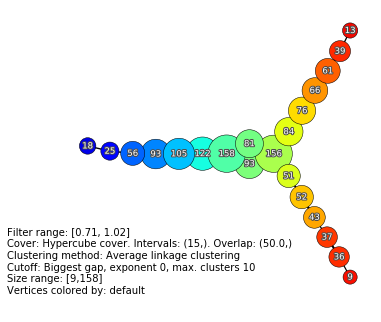

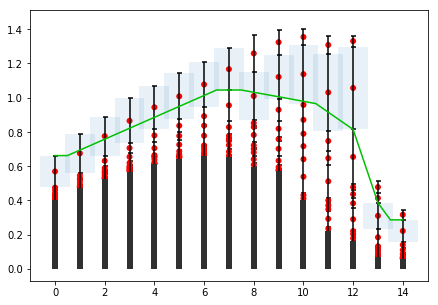

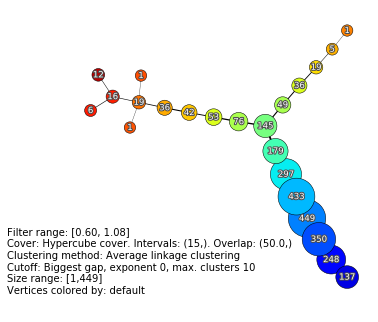

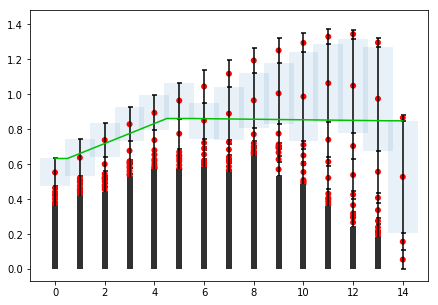

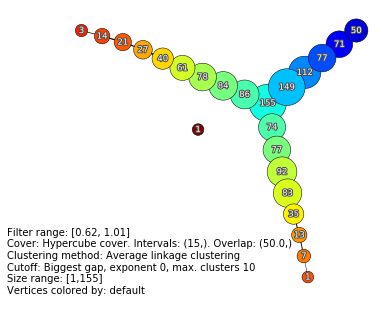

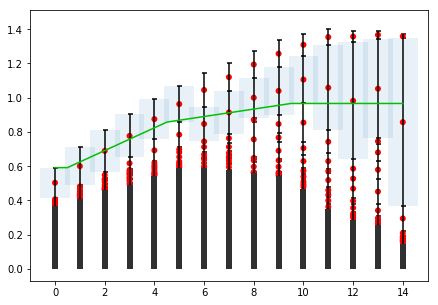

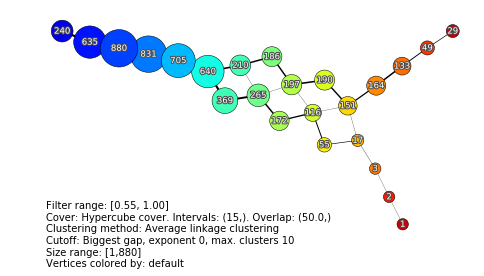

In [16]:
manySunsets = []
for i in range(53):
    manySunsets.append(np.load("./numpy vectors/many_sunset_vectors/sunsets_SURF_{}.npy".format(i+1)))
    
metric = [False, None, None]
filter_func = ["ecc", 2, None, None, None]
cover_params = ["uni", 15, 50]
cluster_num = 2
cutoff_func = ["big", 0, 10]

produceMapperOutput("SURF", manySunsets, "../mapper/mapper outputs/many sunsets/",
                   metric=metric, filter_func=filter_func, cover_params=cover_params,
                   cluster_num=cluster_num, cutoff_func=cutoff_func, savenum=None)